In [4]:
# Imports

import matplotlib.pyplot as plt
import numpy as np

from baseband_analysis.core import BBData

In [2]:
# Load beamformed file

file_in = '/data/chime/baseband/processed/2020/05/07/astro_83390274/OLD/beamform_83390274.h5'
data = BBData.from_file(file_in)
dm = DM = 166.9

(896, 2, 105544)


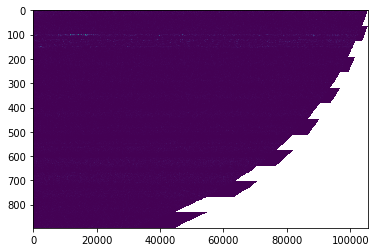

In [3]:
# Load and plot the power matrix

power =  data["tiedbeam_power"][:]
print(power.shape)  # There is only one beam with two polarizations
total_intensity = power.sum(axis=1)  # Sums the polarizations togheter

plt.imshow(
    total_intensity,
    cmap="viridis",
    origin="upper",
    aspect="auto",
    interpolation="nearest",
)

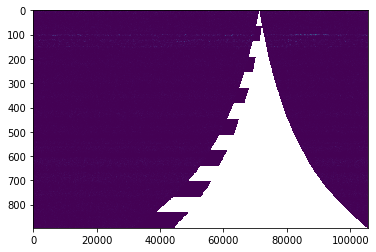

In [4]:
# Align the channels and dedisperse the signal to DM

from baseband_analysis.core.dedispersion import incoherent_dedisp

dedispersed, freq, freq_id = incoherent_dedisp(
    data,
    DM,
    matrix_in=total_intensity,
    fill_wfall=False,
)

plt.imshow(
    dedispersed,
    cmap="viridis",
    origin="upper",
    aspect="auto",
    interpolation="nearest",
)

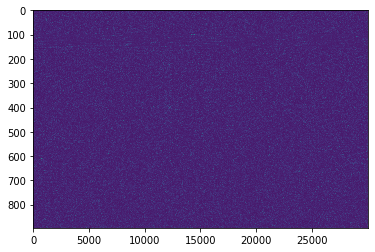

In [7]:
# Select and plot only the region without NaN values
# Normalize the data to have mean = 0 and std = 1

valid_data = dedispersed[:, 0:30000]
mean = np.mean(valid_data, axis=1)
valid_data = valid_data - mean[:, np.newaxis]
std = valid_data.std(axis=1)
valid_data = valid_data / std[:, np.newaxis]

plt.imshow(
    valid_data,
    cmap="viridis",
    origin="upper",
    aspect="auto",
    interpolation="nearest",
)

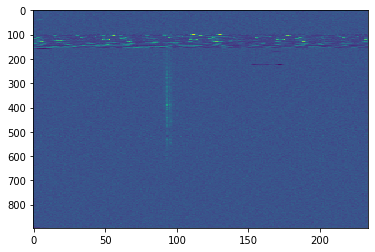

In [8]:
# There is a weak signal barely visible in the middle of the plot
# Downsample of a factor 128 in time to better see the signal

factor = 128
ds = valid_data[..., : valid_data.shape[-1] // factor * factor]
ds = ds.reshape([
    ds.shape[0], 
    ds.shape[1] // factor,
    factor
]).sum(axis=-1) / np.sqrt(factor)  # The division is necessary to keep the units of S/N

plt.imshow(
    ds,
    cmap="viridis",
    origin="upper",
    aspect="auto",
    interpolation="nearest",
)  

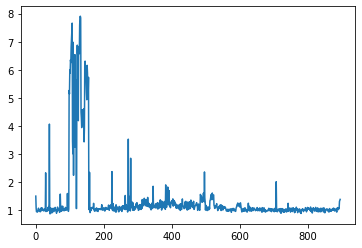

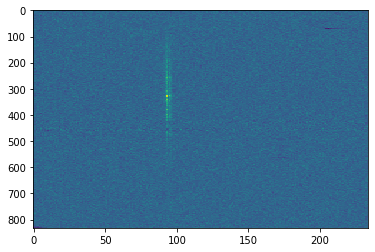

In [10]:
# Identify and remove RFI

spectrum_variation = np.std(ds, axis=1)
plt.plot(spectrum_variation)
plt.show()

idx_clean = np.abs(spectrum_variation) < 2
plt.imshow(
    ds[idx_clean],
    cmap="viridis",
    origin="upper",
    aspect="auto",
    interpolation="nearest",
)

ds_clean = ds[idx_clean]
freq_clean = freq[idx_clean]
freq_id_clean = freq_id[idx_clean]

Text(0, 0.5, 'S/N')

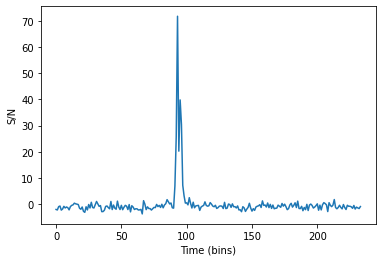

In [12]:
# Plot pulse profile

prof = ds_clean.sum(axis=0) / np.sqrt(ds.shape[0])
plt.plot(prof)
plt.xlabel('Time (bins)')
plt.ylabel('S/N')

In [10]:
# 1. Can you think to ways to improve our estimate of the S/N?
# 2. Can you think to ways to have an higher S/N?

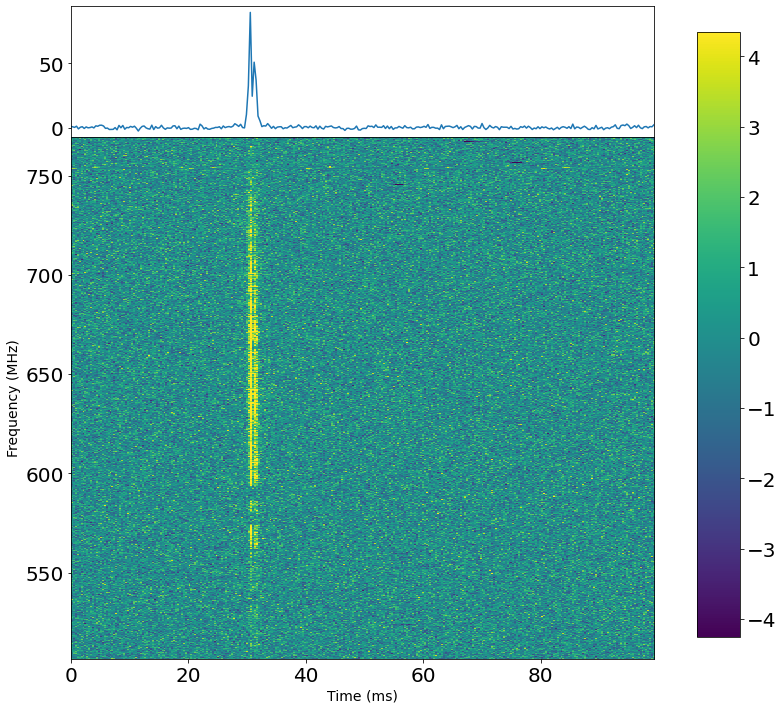

In [14]:
# Here is how all of these steps are done in our code

from baseband_analysis.analysis.snr import get_snr

freq_id_auto, freq_auto, snr = get_snr(
    data,
    DM = DM,
    diagnostic_plots = True,
    downsample = 128
)

Text(0, 0.5, 'S/N')

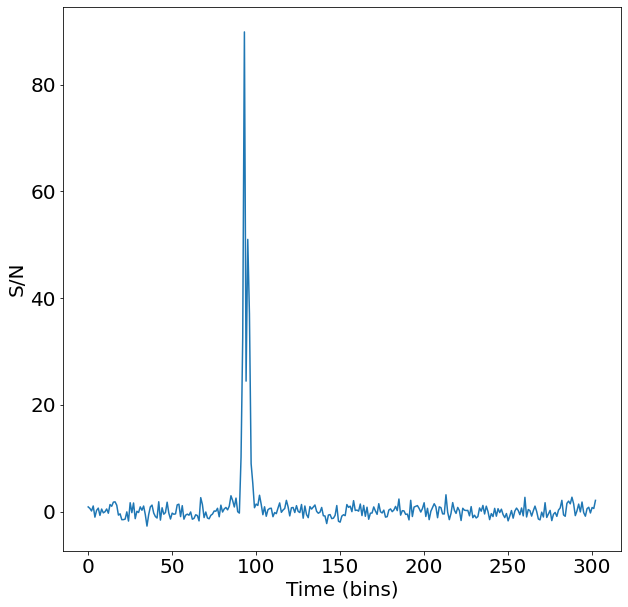

In [15]:
# Plot pulse profile

snr_clean = snr[~np.isnan(snr.sum(axis=1))]
prof = snr_clean.sum(axis=0) / np.sqrt(snr_clean.shape[0])
plt.plot(prof)
plt.xlabel('Time (bins)')
plt.ylabel('S/N')